In [2]:
import pandas as pandas
dataframe = pandas.read_csv("dataset.csv").dropna()
dataframe["date"] = pandas.to_datetime(dataframe['date'], format='%Y-%m-%d %H:%M:%S')
dataframe["datetimestamp"] = dataframe["date"]
dataframe["NSM"] = (dataframe["date"] - pandas.to_datetime(dataframe['date'].dt.date, format='%Y-%m-%d')).dt.total_seconds()
dataframe["week_status"] = dataframe["date"].apply(lambda date: 1 if(date.weekday() <= 4) else 0)
dataframe["day_of_week"] = dataframe["date"].dt.day_name()
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           19735 non-null  datetime64[ns]
 1   Appliances     19735 non-null  int64         
 2   lights         19735 non-null  int64         
 3   T1             19735 non-null  float64       
 4   RH_1           19735 non-null  float64       
 5   T2             19735 non-null  float64       
 6   RH_2           19735 non-null  float64       
 7   T3             19735 non-null  float64       
 8   RH_3           19735 non-null  float64       
 9   T4             19735 non-null  float64       
 10  RH_4           19735 non-null  float64       
 11  T5             19735 non-null  float64       
 12  RH_5           19735 non-null  float64       
 13  T6             19735 non-null  float64       
 14  RH_6           19735 non-null  float64       
 15  T7             1973

In [3]:
from pathlib import Path  
output_dataset_path = Path("./dataframeResult/modifiedDataset.csv")
output_dataset_path.parent.mkdir(parents=True, exist_ok=True)
dataframe.to_csv(Path(output_dataset_path))  
dataframe.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,datetimestamp,NSM,week_status,day_of_week
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,92.0,7.000000,63.000000,5.3,13.275433,13.275433,2016-01-11 17:00:00,61200.0,1,Monday
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,92.0,6.666667,59.166667,5.2,18.606195,18.606195,2016-01-11 17:10:00,61800.0,1,Monday
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,92.0,6.333333,55.333333,5.1,28.642668,28.642668,2016-01-11 17:20:00,62400.0,1,Monday
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,92.0,6.000000,51.500000,5.0,45.410389,45.410389,2016-01-11 17:30:00,63000.0,1,Monday
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,92.0,5.666667,47.666667,4.9,10.084097,10.084097,2016-01-11 17:40:00,63600.0,1,Monday


<Axes: title={'center': 'Appliances energy consumption vs datetimestamp'}, xlabel='datetimestamp', ylabel='Appliances energy consumption(in Wh)'>

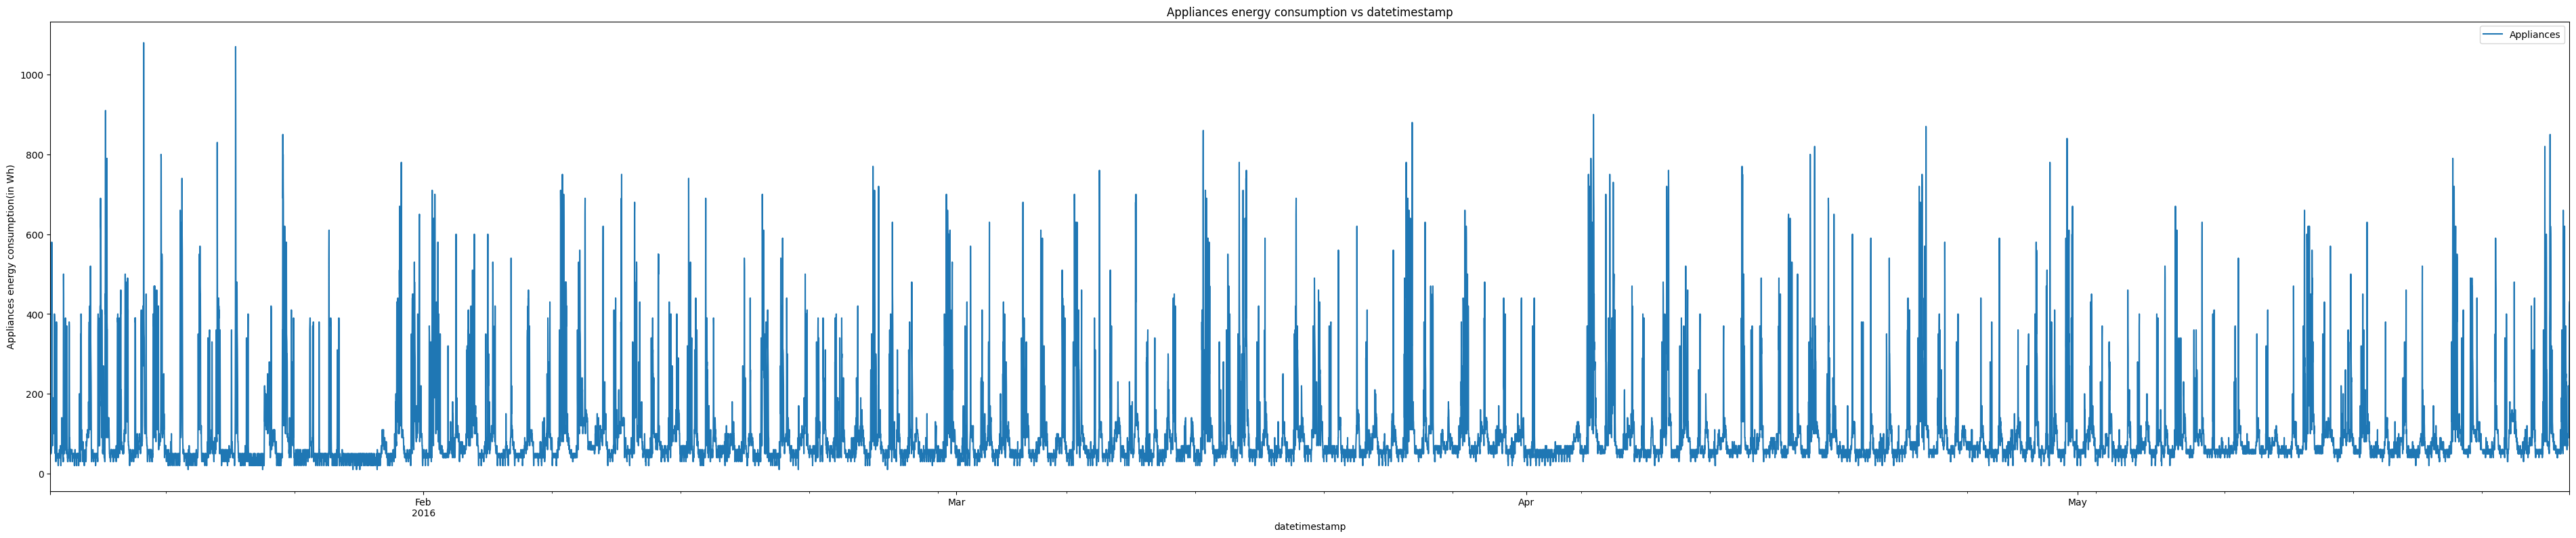

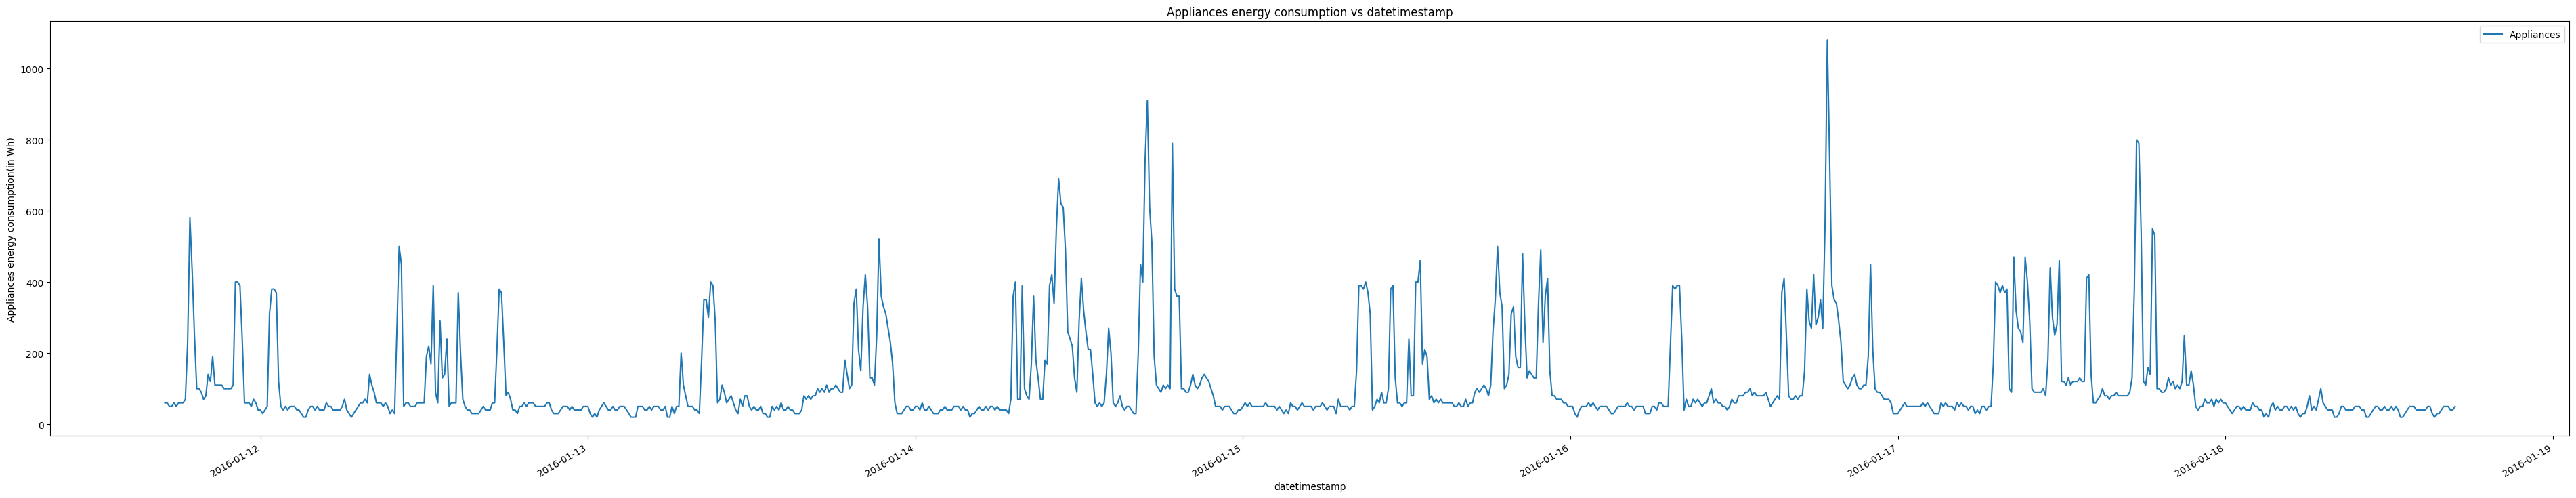

In [4]:
dataframe.plot.line(
    x = "datetimestamp", 
    y = "Appliances", 
    figsize = (48,9), 
    title = "Appliances energy consumption vs datetimestamp", 
    ylabel = "Appliances energy consumption(in Wh)", 
    xlabel = "datetimestamp"
)

import datetime as datetime
dataframe.where((dataframe["datetimestamp"] - dataframe["datetimestamp"].min()) < datetime.timedelta(days = 7)).plot.line(
    x = "datetimestamp", 
    y = "Appliances", 
    figsize = (48,9), 
    title = "Appliances energy consumption vs datetimestamp", 
    ylabel = "Appliances energy consumption(in Wh)", 
    xlabel = "datetimestamp"
)

In [5]:
# Fig: 8 not working
# dataframe["Appliances"].value_counts().plot.hist(
#     x = "Appliances", 
#     y = "Frequency", 
#     figsize = (48,9), 
#     title = "Frquency vs Appliances energy consumption", 
#     ylabel = "Frequency", 
#     xlabel = "Appliances energy consumption(in Wh)"
# )

In [6]:
from pyspark.sql import SparkSession
dataframe = SparkSession.builder.appName("Mining_Big_Data_Assignment_1").getOrCreate().read.csv("./dataframeResult/modifiedDataset.csv", header = True, inferSchema = True)
dataframe.dropna()

from pyspark.sql.types import DoubleType
dataframe = dataframe.withColumn("Appliances", dataframe["Appliances"].cast(DoubleType()))

from pyspark.ml.feature import VectorAssembler
train_dataset, test_dataset = VectorAssembler(inputCols=["lights"], outputCol="assembled_feature_vector").transform(dataframe).randomSplit([0.75, 0.25])

from pyspark.ml.regression import LinearRegression
model = LinearRegression(featuresCol="assembled_feature_vector", labelCol="Appliances").fit(train_dataset).transform(test_dataset)

from pyspark.ml.evaluation import RegressionEvaluator
root_mean_square_error = RegressionEvaluator(labelCol="Appliances", predictionCol="Appliances", metricName="rmse").evaluate(model)

print("Root Mean Square Error = " + str(root_mean_square_error))

23/03/26 03:01:07 WARN Utils: Your hostname, Pranshus-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.0.104 instead (on interface en0)
23/03/26 03:01:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/26 03:01:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


23/03/26 03:01:13 WARN Instrumentation: [e2f9d0c0] regParam is zero, which might cause numerical instability and overfitting.
23/03/26 03:01:13 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , date, Appliances, lights, T1, RH_1, T2, RH_2, T3, RH_3, T4, RH_4, T5, RH_5, T6, RH_6, T7, RH_7, T8, RH_8, T9, RH_9, T_out, Press_mm_hg, RH_out, Windspeed, Visibility, Tdewpoint, rv1, rv2, datetimestamp, NSM, week_status, day_of_week
 Schema: _c0, date, Appliances, lights, T1, RH_1, T2, RH_2, T3, RH_3, T4, RH_4, T5, RH_5, T6, RH_6, T7, RH_7, T8, RH_8, T9, RH_9, T_out, Press_mm_hg, RH_out, Windspeed, Visibility, Tdewpoint, rv1, rv2, datetimestamp, NSM, week_status, day_of_week
Expected: _c0 but found: 
CSV file: file:///Users/pru/Documents/Mining%20Big%20Data/Assignment%201/Crashpit/dataframeResult/modifiedDataset.csv
23/03/26 03:01:13 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
23/03/26 03:01:13 WARN InstanceBuild

23/03/26 03:01:13 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
23/03/26 03:01:14 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , date, Appliances, lights, T1, RH_1, T2, RH_2, T3, RH_3, T4, RH_4, T5, RH_5, T6, RH_6, T7, RH_7, T8, RH_8, T9, RH_9, T_out, Press_mm_hg, RH_out, Windspeed, Visibility, Tdewpoint, rv1, rv2, datetimestamp, NSM, week_status, day_of_week
 Schema: _c0, date, Appliances, lights, T1, RH_1, T2, RH_2, T3, RH_3, T4, RH_4, T5, RH_5, T6, RH_6, T7, RH_7, T8, RH_8, T9, RH_9, T_out, Press_mm_hg, RH_out, Windspeed, Visibility, Tdewpoint, rv1, rv2, datetimestamp, NSM, week_status, day_of_week
Expected: _c0 but found: 
CSV file: file:///Users/pru/Documents/Mining%20Big%20Data/Assignment%201/Crashpit/dataframeResult/modifiedDataset.csv
23/03/26 03:01:14 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , date, Appliances, lights, T1, RH_1, T2, RH_2, T3, RH_3, T4, RH

23/03/26 03:01:15 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/03/26 03:01:15 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , date, Appliances, lights, T1, RH_1, T2, RH_2, T3, RH_3, T4, RH_4, T5, RH_5, T6, RH_6, T7, RH_7, T8, RH_8, T9, RH_9, T_out, Press_mm_hg, RH_out, Windspeed, Visibility, Tdewpoint, rv1, rv2, datetimestamp, NSM, week_status, day_of_week
 Schema: _c0, date, Appliances, lights, T1, RH_1, T2, RH_2, T3, RH_3, T4, RH_4, T5, RH_5, T6, RH_6, T7, RH_7, T8, RH_8, T9, RH_9, T_out, Press_mm_hg, RH_out, Windspeed, Visibility, Tdewpoint, rv1, rv2, datetimestamp, NSM, week_status, day_of_week
Expected: _c0 but found: 
CSV file: file:///Users/pru/Documents/Mining%20Big%20Data/Assignment%201/Crashpit/dataframeResult/modifiedDataset.csv


/Users/pru/opt/miniconda3/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/Users/pru/opt/miniconda3/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


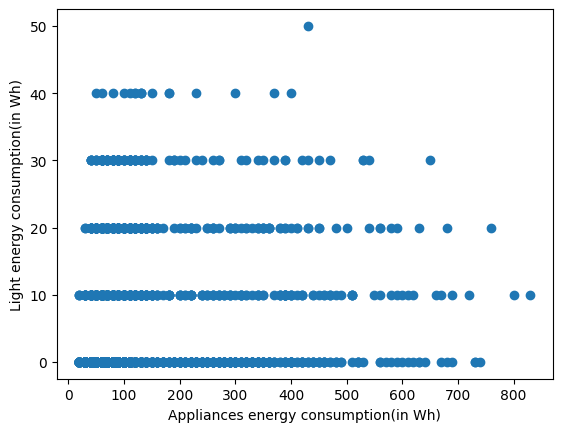

In [7]:
import matplotlib.pyplot as plt

dataframe = model.toPandas()

# plot the predictions versus the actual values
plt.scatter(dataframe['Appliances'], dataframe['lights'])
plt.xlabel('Appliances energy consumption(in Wh)')
plt.ylabel('Light energy consumption(in Wh)')
plt.show()